# Objective
- Build a weighted Nearest neighbor model using Image,Title,Brand and Color
- Featurization to use
 - title:Idf-Word2vec
 - brand:one hot encoding
 - colour:one hot encoding
 - image: VGG-16 CNN

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
import requests
import pickle
warnings.filterwarnings("ignore")

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications



# Load the cleaned data

In [3]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


# Featurization

## Featurize 'title' using Idf-Word2Vec

In [4]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [5]:
# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file which contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

#if you do NOT have RAM >= 12GB, use the code below.

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [6]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [7]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

## Featurize 'brand' and 'color' using one-hot encoding

In [18]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

## Feature 'images' using VGG-16 CNN

In [9]:
# Running this cell will take time,so the files are saved and we can reuse

# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

'''
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('workshop/models/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('workshop/models/16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()
'''

"\n# dimensions of our images.\nimg_width, img_height = 224, 224\n\ntop_model_weights_path = 'bottleneck_fc_model.h5'\ntrain_data_dir = 'images2/'\nnb_train_samples = 16042\nepochs = 50\nbatch_size = 1\n\n\ndef save_bottlebeck_features():\n    asins = []\n    datagen = ImageDataGenerator(rescale=1. / 255)\n    \n    # build the VGG16 network\n    model = applications.VGG16(include_top=False, weights='imagenet')\n    generator = datagen.flow_from_directory(\n        train_data_dir,\n        target_size=(img_width, img_height),\n        batch_size=batch_size,\n        class_mode=None,\n        shuffle=False)\n\n    for i in generator.filenames:\n        asins.append(i[2:-5])\n\n    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)\n    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))\n    \n    np.save(open('workshop/models/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)\n    np.save(open('workshop/mod

In [10]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')

In [52]:
df_asins = list(data['asin'])
asins = list(asins)

# Weighted Similarity

In [12]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from ipywidgets import widgets
from ipywidgets import interact, interactive,fixed,interact_manual

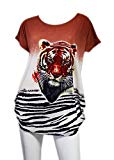

ASIN : B00JXQB5FQ
Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Brown
Euclidean Distance from input image: 0.8787302983865323
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


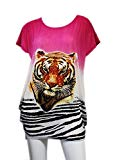

ASIN : B00JXQASS6
Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand : Si Row
Color : Pink
Euclidean Distance from input image: 13.450150888384401
Amazon Url: www.amzon.com/dp/B00JXQASS6


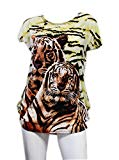

ASIN : B00JXQCUIC
Product Title:  yellow tiger tshirt tiger stripes  l 
Brand : Si Row
Color : Yellow
Euclidean Distance from input image: 18.012345926057243
Amazon Url: www.amzon.com/dp/B00JXQCUIC


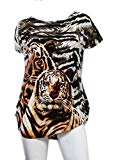

ASIN : B00JXQCWTO
Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Brand : Si Row
Color : Brown
Euclidean Distance from input image: 19.174543202647612
Amazon Url: www.amzon.com/dp/B00JXQCWTO


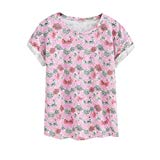

ASIN : B071FCWD97
Product Title:  kawaii pastel tops tees pink flower design 
Brand : Namnoi Clothing Store
Color : As Show
Euclidean Distance from input image: 20.622412508097533
Amazon Url: www.amzon.com/dp/B071FCWD97


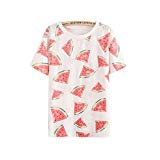

ASIN : B01JUNHBRM
Product Title:  womens thin style tops tees pastel watermelon print 
Brand : Namnoi Clothing Store
Color : As show
Euclidean Distance from input image: 20.732257553062098
Amazon Url: www.amzon.com/dp/B01JUNHBRM


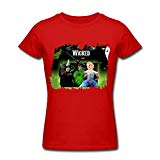

ASIN : B01KUN4VWE
Product Title:  womans wicked musical poster shirts red xxl 
Brand : vcord
Color : Red
Euclidean Distance from input image: 20.770853590995387
Amazon Url: www.amzon.com/dp/B01KUN4VWE


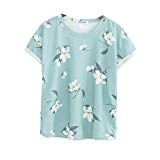

ASIN : B071SBCY9W
Product Title:  kawaii pastel tops tees baby blue flower design 
Brand : Namnoi Clothing Store
Color : As Show
Euclidean Distance from input image: 20.81900950345302
Amazon Url: www.amzon.com/dp/B071SBCY9W


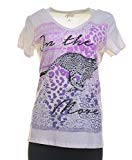

ASIN : B01CUPYBM0
Product Title:  edv cheetah run purple multi xl 
Brand : Styleco
Color : White
Euclidean Distance from input image: 20.877943849653942
Amazon Url: www.amzon.com/dp/B01CUPYBM0


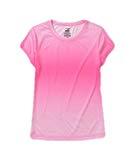

ASIN : B01F7PHXY8
Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Brand : Danskin Now
Color : Pink Hombre
Euclidean Distance from input image: 20.92826849755371
Amazon Url: www.amzon.com/dp/B01F7PHXY8


In [135]:
def weighted_sim(doc_id, wT, wB, wC, wI,wtype, num_results):
    # doc_id: apparel's id in given corpus
    # wT: weight for 'title' idf-w2v features
    # wB: weight for brand
    # wC: weight for color features
    # wI: weight for Images

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    doc_id1 = asins.index(df_asins[doc_id])
    
    title_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_dist = pairwise_distances(color_features, color_features[doc_id])
    type_dist = pairwise_distances(type_features, type_features[doc_id])
    
    doc_id1 = asins.index(df_asins[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id1].reshape(1,-1))
    
    pairwise_dist = ((wT * title_dist)+(wB * brand_dist)+(wC * color_dist)+(wtype*type_dist)+\
                     (wI * image_dist))/float(wT+wB+wC+wtype+wI)

    # np.argsort will return indices of n smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the n smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the n smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        rows = data[['medium_image_url','title','asin','brand','color','product_type_name']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('ASIN :',row['asin'])
            print('Product Title: ', row['title'])
            print('Brand :',row['brand'])
            print('Color :',row['color'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])
        print('='*100)
weighted_sim(12566,2,1,1,5,3,10)

In [136]:
# Weights
# title
weight_range = [ii for ii in range(101)]

title_weight_dropdown = widgets.Dropdown(options=weight_range, value = 2 ,description='title_wt',disabled=False)

brand_weight_dropdown = widgets.Dropdown(options=weight_range, value = 1 ,description='brand_wt:',disabled=False)

color_weight_dropdown = widgets.Dropdown(options=weight_range, value = 1 ,description='color_wt:',disabled=False)

type_weight_dropdown = widgets.Dropdown(options=weight_range, value = 3 ,description='type_wt:',disabled=False)

image_weight_dropdown = widgets.Dropdown(options=weight_range, value = 7 ,description='image_wt:',disabled=False)

num_result_dropdown = widgets.Dropdown(options=weight_range, value = 12,description='# results:',disabled=False)




In [137]:
interact(weighted_sim,
         doc_id = fixed(1),
         wT = title_weight_dropdown,
         wB = brand_weight_dropdown,
         wC = color_weight_dropdown,
         wtype = type_weight_dropdown,
         wI = image_weight_dropdown,
         num_results = num_result_dropdown)

interactive(children=(Dropdown(description='title_wt', index=2, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,…

<function __main__.weighted_sim(doc_id, wT, wB, wC, wI, wtype, num_results)>